In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.notebook as nb
import matplotcheck.autograde as ag
import matplotcheck.raster as rs

In [2]:
# YOUR CODE HERE
import warnings
import os
from glob import glob
import re  # regular expressions
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from shapely.geometry import box
warnings.simplefilter('ignore')

# Adjust plot parameters throughout notebook 
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

# Set working directory to 'earth-analytics' and data folder.
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [3]:
# Add your function here. Do NOT modify the function name
def crop_stack_data(files_to_crop, crop_dir_path, crop_bound):
    """Crops a set of tif files and saves them 
    in a crop directory. Returns a stacked numpy 
    array of bands.
    
    Parameters
    ----------
    files_to_crop : list
        List of paths to multispectrum scenes 
        (.tiff) to be cropped.
    
    crop_dir_path : string
        The path to an output directory.  
        use conditional statment to create one,
        if not in existance. 
        The directory will store, 
        cropped and stacked bands.
        
    crop_bound : gpd (GeoPandas GeoDataFrame)
        Vector shape file geodataframe used for 
        cropping area of interest from the files_to_crop.
    
    Returns
    -------
    all_bands_stack : numpy array(s)
        Stacked and cropped numpy array bands 
        (our new aoi's).
    
    fire_crop_bound : GeoPandas GeoDataFrame
        A vector shape file that either shares 
        the crs of the stacked bands or is 
        reprojected from the crop_bound crs.
    """
    if not os.path.exists(crop_dir_path):
        os.mkdir(crop_dir_path)
        
    # Reproject boundary .shp to geotiff crs 
    with rio.open(files_to_crop[0]) as landsat_src:
        if not crop_bound.crs == landsat_src.crs:
            fire_crop_bound = crop_bound.to_crs(
                                  landsat_src.crs)
            extent = plotting_extent(landsat_src)
#         crop_bound = crop_bound.to_crs(src.crs)
 
    #  crop images using earthpy 
    es.crop_all(raster_paths=files_to_crop,
                output_dir=crop_dir_path,
                geoms= fire_crop_bound,
                overwrite=True)
    
    # Retrieve cropped bands from the new directory
    all_bands = sorted(glob(os.path.join(
                       crop_dir_path, "*.tif")))
    # Stack cropped bands
    all_stack_bands, stack_bands_meta = es.stack(all_bands)
    
    # return cropped, stacked bands and fire boundary
    return all_stack_bands, stack_bands_meta, fire_crop_bound

In [38]:
# Add your function here. Do NOT modify the function name
def mask_data(arr, path_to_qa):   
    """Function that masks numpy arrays 
    using qa layer.
    
    Parameters
    ----------
    arr : numpy array
        Numpy array(s) of bands of aoi       
    
    path_to_qa : str
        Path to QA layer(s) associated with each band        
    
    Returns
    -------
    arr : masked numpy array
        Updated numpy array(s) of bands with high cloud
        confidence, clouds and cloud shadows masked.        
    """
    # 1. open the qa layer
    with rio.open(path_to_qa[0]) as src:
        mask_arr = src.read(1)
        
    # Cloud mask values
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # 2. Mask the numpy array 
    if any(i in np.unique(mask_arr) for i in all_masked_values):
        landsat_masked_bands = em.mask_pixels(arr,
                                              mask_arr,
                                              vals=all_masked_values)
        return landsat_masked_bands
    else:
        print("There are no pixels to mask")
        return arr

In [5]:
# Add your function here. Do NOT modify the function name
def classify_dnbr(arr):
    """Function that creates a new numpy array of classified
    values using difference normalized burn ratio (dNBR) as
    numpy array. 
    
    Parameters
    ----------
    arr : Numpy array
        Numpy array(s) containing dNBR data.        
    
    Returns
    -------
    arr_class : Numpy array
        Numpy array(s) containing reclassified 
        dNBR values in 5 possible classes.        
    """

    # YOUR CODE HERE
    # bins to define fire severity
    class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]
    
    # code to classify dnbr values 
    arr_reclass = np.digitize(arr, class_bins)
        
    return arr_reclass

In [7]:
# Set working directory using conditional statement
workdir_path = (os.path.join(et.io.HOME, "earth-analytics"))

if os.path.exists(workdir_path):
    os.chdir(workdir_path)
else:
    print("Path does not exist yet, but making it now!")
    os.mkdir(workdir_path)
    os.chdir(workdir_path)

# Check working directory
os.getcwd()

'C:\\Users\\bina_\\earth-analytics'

In [8]:
# all_sites contain path to both sites 
base_path = os.path.join("data","sd_fires_2014", "sites")

# Define list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

['data\\sd_fires_2014\\sites\\BERNARDO\\',
 'data\\sd_fires_2014\\sites\\COCOS\\',
 'data\\sd_fires_2014\\sites\\POINSETTIA\\',
 'data\\sd_fires_2014\\sites\\PULGAS\\',
 'data\\sd_fires_2014\\sites\\TOMAHAWK\\']

In [9]:
# Import SJER shape file and visualize it using geopandas.
base_path = os.path.join("data","sd_fires_2014", "sites")
boundary_path = os.path.join(base_path,
                                "BERNARDO", "vector",
                              "bernardo_box.shp")

# Open a shapefile using geopandas and change CRS.
bernardo_bounds = gpd.read_file(boundary_path)
# sjer_boundary= sjer_bounds.to_crs(epsg=32611)
print(bernardo_bounds.total_bounds)
print(bernardo_bounds.shape)
print(bernardo_bounds.crs)

###############
boundary_path2 = os.path.join(base_path,
                                "COCOS", "vector",
                              "cocos_box.shp")
cocos_bounds = gpd.read_file(boundary_path2)
print("COCOS_fire_bdy:", cocos_bounds.total_bounds)
print(cocos_bounds.shape)
print(cocos_bounds.crs)

# View data attributes and CRS.

# print(sjer_boundary.crs)

[ 262667.59617768 -555228.62003459  269261.95448877 -550853.2180618 ]
(1, 2)
{'init': 'epsg:3310'}
COCOS_fire_bdy: [ 263495.8162 -542742.8268  268961.022  -538848.5866]
(1, 2)
{'init': 'epsg:3310'}


In [10]:
from rasterio.plot import plotting_extent
# # Define path for Colorado Springs pre-fire data
bernardo_path = os.path.join(base_path,  "BERNARDO",
                    "landsat-crop", "landsat20140509",
                             "LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif")

with rio.open(bernardo_path) as bernardo_src:
    bernardo_csf = bernardo_src.read()
#     clip_extent= [box(*naip_2015_src.bounds)]
    bernardo_csf_meta = bernardo_src.meta
    extent = plotting_extent(bernardo_src)
    fire_boundary= bernardo_bounds.to_crs(bernardo_src.crs)

# View and metadata shape 
print(bernardo_csf_meta)
print(bernardo_csf.shape)
print(fire_boundary.crs)

# cocos_path = os.path.join(base_path,  "COCOS",
#                     "landsat-crop", "landsat20140509",
#                             "LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif")
# with rio.open(cocos_path) as cocos_src:
#     cocos_csf = cocos_src.read()
# #     clip_extent= [box(*naip_2015_src.bounds)]
#     cocos_csf_meta = cocos_src.meta
#     extent = plotting_extent(cocos_src)
#     fire_boundary= cocos_bounds.to_crs(cocos_src.crs)
    
# # View and metadata shape 
# print(cocos_csf_meta)
# print(cocos_csf.shape)
# print(fire_boundary.crs)
        


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 1.0, 'width': 7681, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 366885.0,
       0.0, -30.0, 3787815.0)}
(1, 7821, 7681)
EPSG:32611


In [27]:
# # YOUR CODE HERE
# # Define list of directories in "sites"
# all_sites = glob(os.path.join(base_path, "*/"))
# all_sites.sort()
# all_sites

# # Create an empty lists to store site name, date, and mean ndvi
# composite_list = []
# cleaned_landsat_ndvi = {}
# # cleaned_landsat_nbr = {}

# # Define the directory name, it is an explicit directory.
# landsat_dir = "landsat-crop"

# # Loop through each site directory
# # first loop to go to harv and sjer direcotry
# for site_dir in all_sites:
    
#     # Get site name
#     site = os.path.basename(os.path.normpath(site_dir)) 
# #     print(site_dir)
# #     print(site)
# #     print(date)
    
#     # Define a dynamic boundary path for the site
#     boundary_path = os.path.join(site_dir, "vector", 
#                                  site + "_box.shp")

# #     print(boundary_path)
#     fire_boundary = gpd.read_file(boundary_path)
# #     print(fire_boundary)
   
#     # Get a list of subdirectories for that site
#     new_path = os.path.join(site_dir, landsat_dir)
# #     print("new path:", new_path)
    
#     # all dirs is acessing all image directory
#     # inner loop iterates on each of these (23)x2 subdirectories.
#     all_dirs = glob(new_path + "/*/")  
#     all_dirs.sort()
# #     print("all directories:", all_dirs)

#     # Loop through each subdirectory for site
#     # the second loop opens tif files
#     for dir in all_dirs:
#         date = os.path.basename(os.path.normpath(dir))[-8:] 
# #         print(date)
        
#         # Get all bands in each subdirectory for site
#         site_bands = glob(dir + "*.tif")
#         site_bands.sort()
#         print(site_bands)
# #         with rio.open(site_bands[1]) as src:
# #         fire_boundary_prj= fire_boundary.to_crs(bernardo_src.crs)
#         # create plotting extent
#         with rio.open(site_bands[3]) as src:
#             extent = plotting_extent(src)
#             fire_boundary_prj= fire_boundary.to_crs(src.crs)
# #             print(src.crs)
#         # Run function to calculate NDVI for that subdirectory (scene)
#             ndvi_clean = open_band_ndvi(bands= 
#                             site_bands, site_bounds= fire_boundary_prj)
# #         print(ndvi_clean.mean())
#             composite_list.append([site, ndvi_clean, date])
#         # add cleaned ndvi_clean to the dictionary
#             cleaned_landsat_ndvi[date] = {site: ndvi_clean}

# print(cleaned_landsat_ndvi)


['data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_radsat_qa.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_aerosol.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_band1.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_band2.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_band3.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_band4.tif', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\LC08_L1TP_040037_20140509_20170307_01_T1_sr_

NameError: name 'open_band_ndvi' is not defined

In [42]:
# Create loop to process Landsat data in this cell
# Setting path to scene directories
# Define list of directories in "sites" 
## all_sites is replaced with all_dirs
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
# all_sites
# print(all_sites)

# data_path = os.path.join("earthpy-downloads",
#                          "landsat-coldsprings-hw")
# all_dirs = glob(os.path.join(data_path, "L*/"))
# print(all_dirs)

#### Create empty dictionary
# cleaned_landsat_data = {}
##* Create an empty lists to store site name, date, and mean ndvi
composite_list = []
cleaned_landsat_data = {}
# # cleaned_landsat_nbr = {}

# ##* Define the directory name, it is an explicit directory.
landsat_dir = "landsat-crop"
# Loop through each site directory
# first loop to go to harv and sjer direcotry
for site_dir in all_sites:
    
    # Get site name
    site = os.path.basename(os.path.normpath(site_dir)) 
    print(site_dir)
#     print(site)
#     print(date)
    
    # Define a dynamic boundary path for the site
    boundary_path = os.path.join(site_dir, "vector", 
                                 site + "_box.shp")

#     print("Dyanmic boundary path:", boundary_path)
    fire_boundary = gpd.read_file(boundary_path)
#     print("Dyanmic fire boundary:", fire_boundary)
   
    # Get a list of subdirectories for that site
    new_path = os.path.join(site_dir, landsat_dir)
#     print("new path:", new_path)
    # Loop through each subdirectory for site
    # the second loop opens tif files
    #####  dir is replaced by scenes
    for scenes in all_dirs:
        date = os.path.basename(os.path.normpath(scenes))[-8:]
#         print(all_dirs)
        print(date)
        
        # Get all bands in each subdirectory for site
        site_bands = glob(dir + "*.tif")
        site_bands.sort()
#         print(site_bands)
        crop_path = os.path.join(scenes, "cropped")
        if not os.path.exists(crop_path):
            os.mkdir(crop_path)
            print(crop_path)

# # Get all tif files in the directory
# for scenes in all_dirs:
# #     print("path: ", scenes)

#     # Get all tif files in landsat_dir, the directory
#     all_scenes = sorted(glob(os.path.join(scenes, "*.tif")))
#     crop_path = os.path.join(scenes, "cropped")
#     if not os.path.exists(crop_path):
#         os.mkdir(crop_path)
# #     print(crop_path)

#     # Get scenes and date from the landsat_scene
#     landsat_scene = os.path.basename(os.path.normpath(scenes))
#     date = landsat_scene[10:18]
#     print("Landsat image date: ", date)

        # crop & stack data
        stacked_bands, stacked_bands_meta, fire_crop_bound = crop_stack_data(
                                     files_to_crop=site_bands,
                                     crop_dir_path=crop_path,
                                     crop_bound=fire_boundary)

        # Paths to cropped qa and bands
        cropped_qa = glob(os.path.join(crop_path,
                                   "*pixel**crop*.tif"))
        cropped_scenes = sorted(glob(os.path.join(crop_path,
                                              "*band*")))

        # Mask all landsat scenes of bad pixels and remove nodata
        bands_arr, bands_meta = es.stack(cropped_scenes, nodata=-9999)
        cleaned_landsat_data[date] = mask_data(bands_arr, cropped_qa)

        # create plotting extent
        with rio.open(cropped_scenes[3]) as landsat_src:
            extent = plotting_extent(landsat_src)
        
# print("plotting extent:", extent)
# print("fire cropped boundary CRS:", fire_crop_bound.crs)
# print(cleaned_landsat_data)

data\sd_fires_2014\sites\BERNARDO\
20140509
There are no pixels to mask
20140525
There are no pixels to mask
data\sd_fires_2014\sites\COCOS\
20140509
There are no pixels to mask
20140525
There are no pixels to mask
data\sd_fires_2014\sites\POINSETTIA\
20140509
20140525
data\sd_fires_2014\sites\PULGAS\
20140509
20140525
data\sd_fires_2014\sites\TOMAHAWK\
20140509
There are no pixels to mask
20140525
There are no pixels to mask


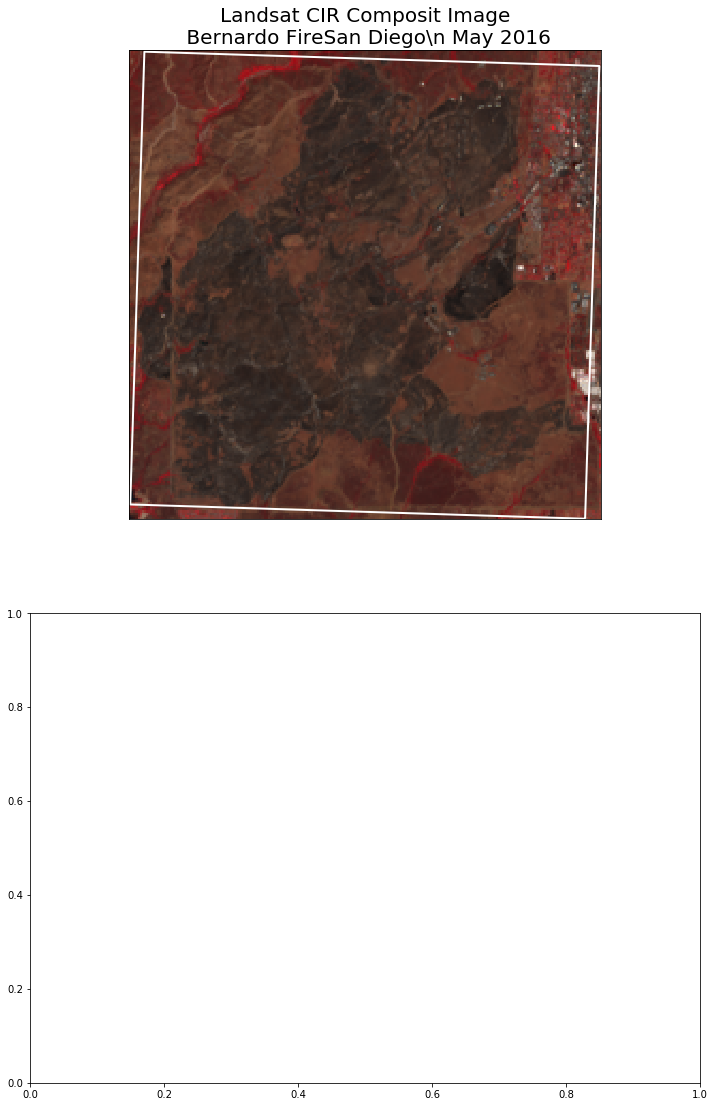

In [44]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 19))
offset=-.03
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["20140525"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax1,
            title="Landsat CIR Composit Image\n Bernardo Fire"
            r"San Diego\n May 2016")
fire_crop_bound.plot(ax=ax1, color="None",
                     edgecolor="white", linewidth=2)